In [41]:
"""
This is a Skorch implementation using PyTorch's ImageFolder and DataLoader for loading images.
The model is trained using backpropagation with the Adam optimizer and CrossEntropyLoss for 
multi-class classification. This approach leverages gradient-based optimization to update
the neural network's weights.


Hypothesis: "For the brain tumor classification dataset, 
a Neural Network model will outperform K-Nearest Neighbors (KNN) and Support Vector Machine (SVM) 
in terms of classification accuracy due to its ability to capture complex patterns in the data. 
However, KNN might be more efficient for small datasets, 
and SVM may offer a balance between interpretability and performance."

"""
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, cross_val_score
from skorch import NeuralNetClassifier
import torch.nn as nn
import torch.nn.functional as F

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# The training data has 4 classes of brain tumors
base_dir = '/home/ec2-user/SageMaker/ML-Algorithm-Benchmarks/data/brain_tumor/Training'

# Define transformations to resize images and normalize pixel values
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize to match target size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Load the dataset
dataset = datasets.ImageFolder(root=base_dir, transform=transform)

# Split the dataset into training and testing sets (80% train, 20% test)
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, _ = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed))

# Convert DataLoader dataset to NumPy arrays for cross-validation
# def dataloader_to_numpy(loader):
#     X = []
#     y = []
#     for inputs, labels in loader:
#         X.append(inputs)
#         y.append(labels)
    
#     # Convert to NumPy outside the loop
#     X = torch.cat(X).cpu().numpy()
#     y = torch.cat(y).cpu().numpy()
    
#     return X, y

# Create DataLoader for both training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)


# Check the class names (to verify the correct labels are being loaded)
class_names = dataset.classes
print("Class names:", class_names)

# Now X_train and X_test are represented by train_loader and test_loader


Class names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


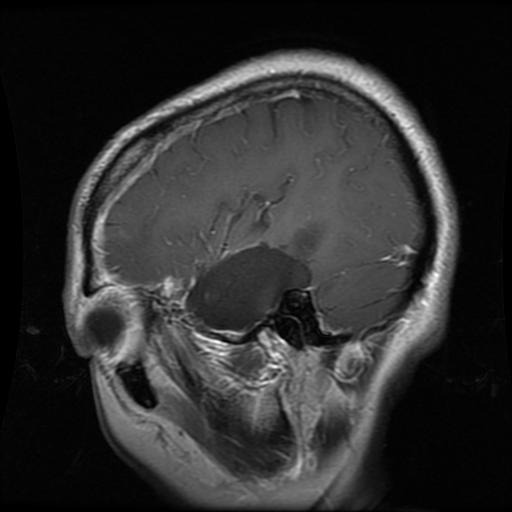

In [34]:
from PIL import Image

# Use backslashes to escape the spaces in the file name
img = Image.open('/home/ec2-user/SageMaker/ML-Algorithm-Benchmarks/data/brain_tumor/Training/glioma_tumor/gg (100).jpg')

# Display the image
img.show()


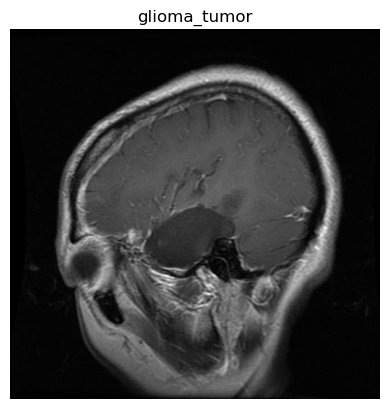

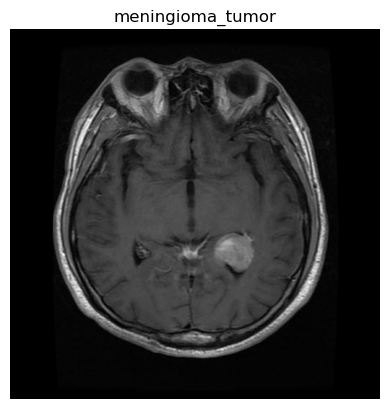

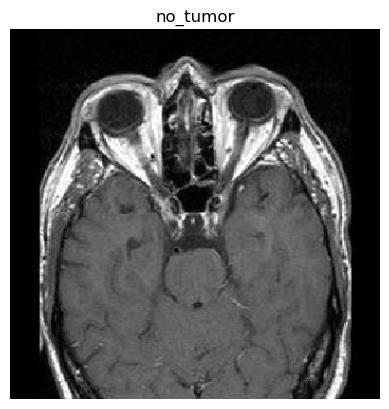

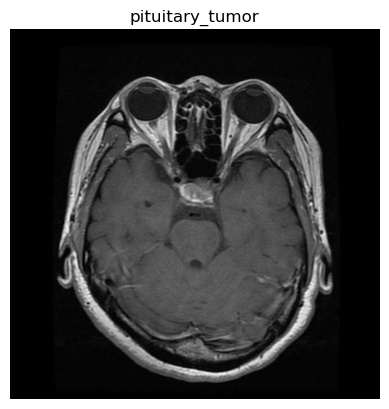

In [35]:
from PIL import Image
import matplotlib.pyplot as plt

# Define paths for each class
image_paths = {
    'glioma_tumor': '/home/ec2-user/SageMaker/ML-Algorithm-Benchmarks/data/brain_tumor/Training/glioma_tumor/gg (100).jpg',
    'meningioma_tumor': '/home/ec2-user/SageMaker/ML-Algorithm-Benchmarks/data/brain_tumor/Training/meningioma_tumor/m (100).jpg',
    'no_tumor': '/home/ec2-user/SageMaker/ML-Algorithm-Benchmarks/data/brain_tumor/Training/no_tumor/1.jpg',
    'pituitary_tumor': '/home/ec2-user/SageMaker/ML-Algorithm-Benchmarks/data/brain_tumor/Training/pituitary_tumor/p (1).jpg',
}

# Display each image using matplotlib
for tumor_type, img_path in image_paths.items():
    # Open the image
    img = Image.open(img_path)
    
    # Plot the image using matplotlib
    plt.imshow(img)
    plt.title(tumor_type)
    plt.axis('off')  # Turn off axis labels
    plt.show()


In [42]:
"""
Define a neural network

"""

import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 1st convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 2nd convolutional layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 3rd convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.fc1 = nn.Linear(64 * 18 * 18, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 4)  # Output layer for 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply ReLU and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply ReLU and pooling
        x = self.pool(F.relu(self.conv3(x)))  # Apply ReLU and pooling
        x = x.view(-1, 64 * 18 * 18)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x


In [1]:
"""
Manual cross-validation using Skorch and PyTorch's DataLoader for image classification
"""
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from skorch import NeuralNetClassifier
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.nn.functional as F

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# The training data has 4 classes of brain tumors
base_dir = '/home/ec2-user/SageMaker/ML-Algorithm-Benchmarks/data/brain_tumor/Training'

# Define transformations to resize images and normalize pixel values
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize to match target size
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Load the dataset
dataset = datasets.ImageFolder(root=base_dir, transform=transform)

# Define CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 18 * 18, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 18 * 18)  # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define Skorch classifier
net = NeuralNetClassifier(
    CNN,
    max_epochs=10,
    lr=0.001,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Manual 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

fold_accuracies = []
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold + 1}')
    
    # Subset the dataset into train and validation sets
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    
    # Extract data and labels from subsets
    def extract_data_and_labels(subset):
        loader = DataLoader(subset, batch_size=len(subset), shuffle=False, num_workers=0)
        inputs, labels = next(iter(loader))
        return inputs, labels

    X_train, y_train = extract_data_and_labels(train_subset)
    X_val, y_val = extract_data_and_labels(val_subset)
    
    # Train the model with explicit labels
    net.fit(X_train, y_train)

    # Validate the model
    accuracy = net.score(X_val, y_val)
    fold_accuracies.append(accuracy)
    print(f'Fold {fold + 1} accuracy: {accuracy * 100:.2f}%')

# Calculate the average accuracy across all folds
avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f'Average accuracy across all folds: {avg_accuracy * 100:.2f}%')


Fold 1
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        5.5178       0.2826        1.3886  33.5855
      2        1.3968       0.2935        1.3860  34.0115
      3        1.3879       0.2935        1.3848  35.9958
      4        1.3847       0.3283        1.3819  33.2147
      5        1.3882       0.2935        1.3837  34.3518
      6        1.3847       0.2935        1.3810  34.8436
      7        1.3796       0.2935        1.3767  33.0326
      8        1.3863       0.2935        1.3781  34.6866
      9        1.3887       0.2935        1.3760  34.2112
     10        1.3739       0.3196        1.3654  33.4764
Fold 1 accuracy: 29.27%
Fold 2
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        3.7824       0.2891        1.3894  34.5431
      2       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


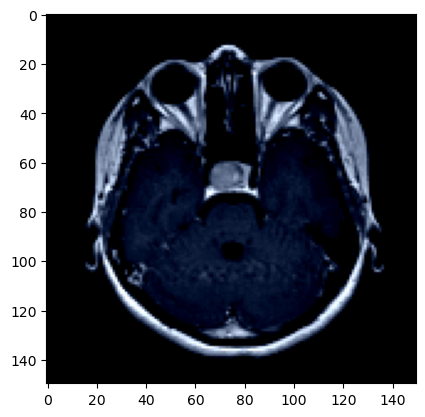

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: pituitary_tumor
Predicted label: pituitary_tumor
------------------------------


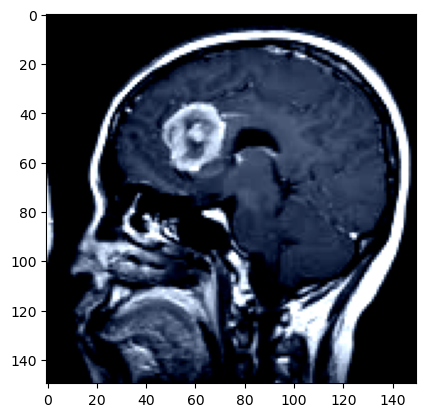

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: meningioma_tumor
Predicted label: no_tumor
------------------------------


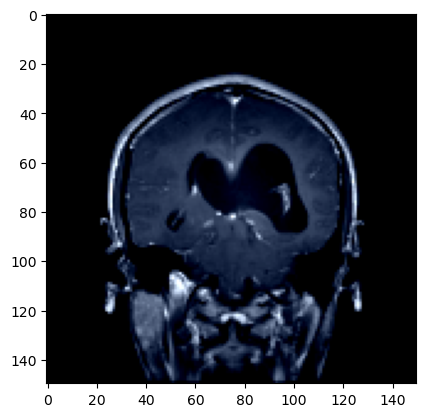

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: glioma_tumor
Predicted label: meningioma_tumor
------------------------------


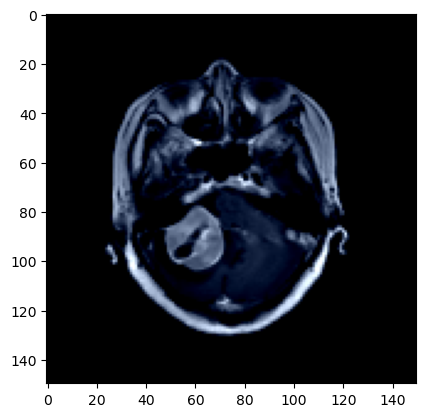

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: meningioma_tumor
Predicted label: meningioma_tumor
------------------------------


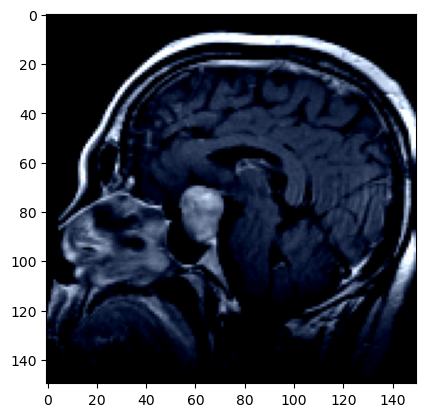

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: pituitary_tumor
Predicted label: pituitary_tumor
------------------------------


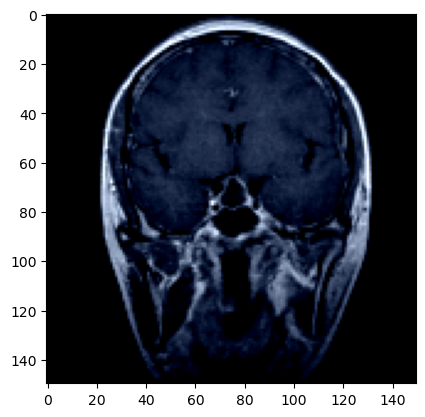

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: pituitary_tumor
Predicted label: pituitary_tumor
------------------------------


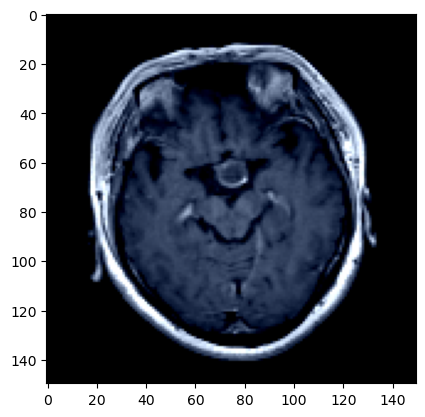

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: pituitary_tumor
Predicted label: pituitary_tumor
------------------------------


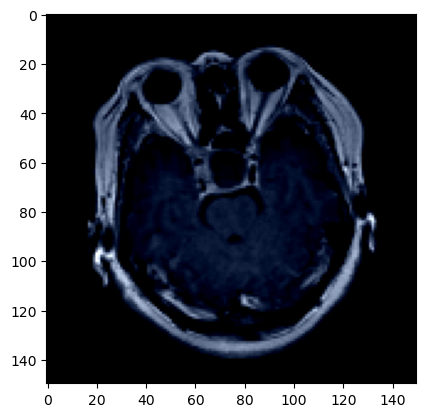

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: pituitary_tumor
Predicted label: pituitary_tumor
------------------------------


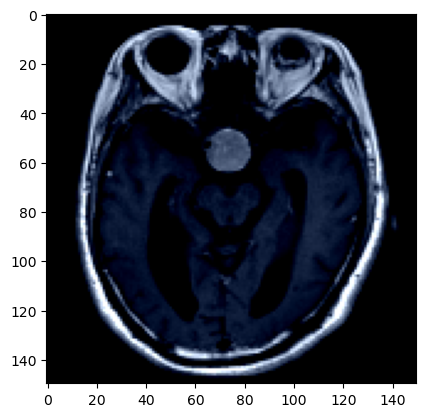

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: pituitary_tumor
Predicted label: pituitary_tumor
------------------------------


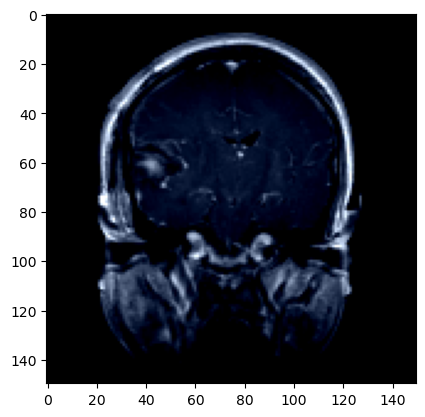

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: glioma_tumor
Predicted label: meningioma_tumor
------------------------------


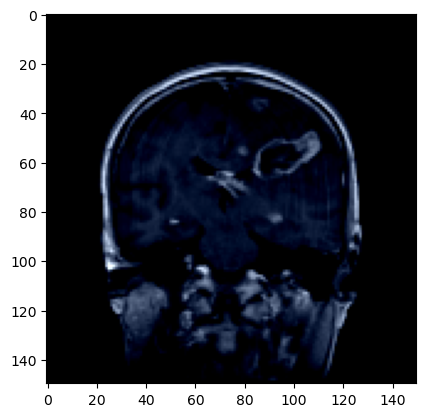

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: glioma_tumor
Predicted label: meningioma_tumor
------------------------------


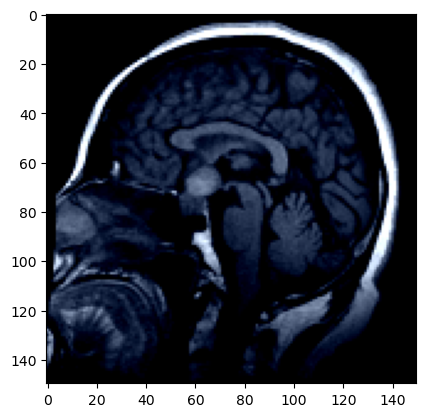

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: pituitary_tumor
Predicted label: pituitary_tumor
------------------------------


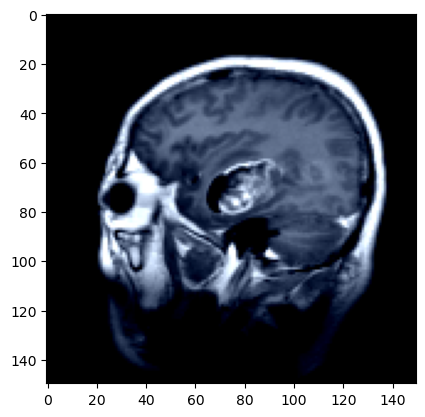

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: glioma_tumor
Predicted label: meningioma_tumor
------------------------------


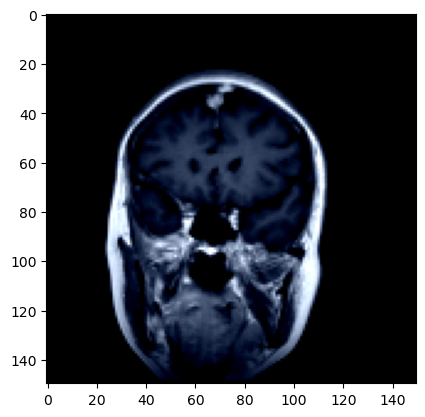

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: meningioma_tumor
Predicted label: meningioma_tumor
------------------------------


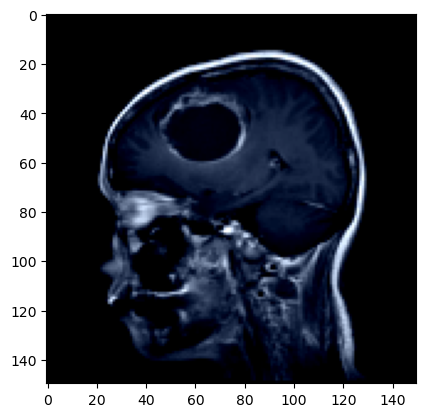

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: glioma_tumor
Predicted label: meningioma_tumor
------------------------------


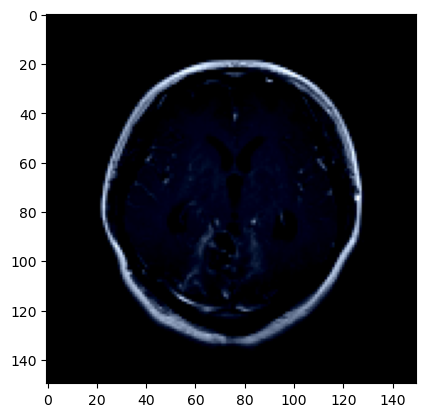

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: glioma_tumor
Predicted label: meningioma_tumor
------------------------------


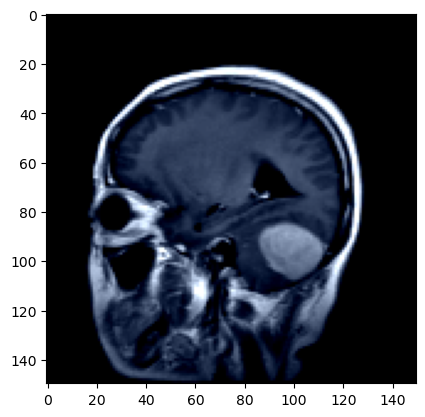

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: meningioma_tumor
Predicted label: meningioma_tumor
------------------------------


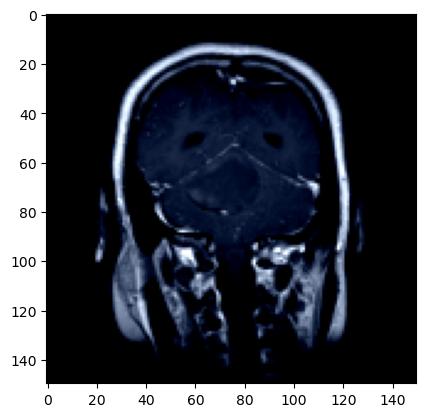

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: glioma_tumor
Predicted label: meningioma_tumor
------------------------------


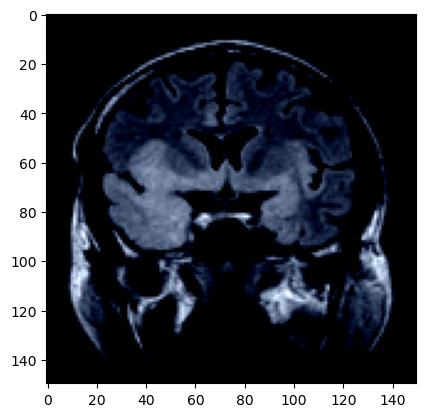

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual label: no_tumor
Predicted label: no_tumor
------------------------------


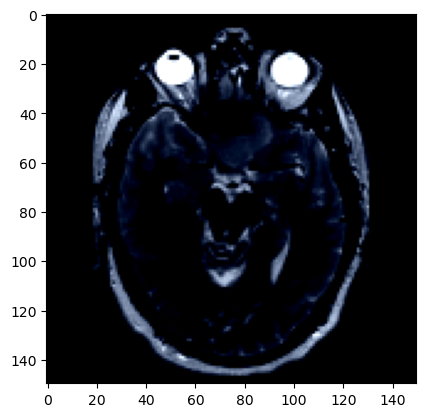

Actual label: no_tumor
Predicted label: pituitary_tumor
------------------------------


In [6]:
import torch
import matplotlib.pyplot as plt

# Assuming you have already loaded the dataset and defined class_names
class_names = dataset.classes

# DataLoader for the validation set
val_loader = DataLoader(val_subset, batch_size=1, shuffle=True, num_workers=0)

# Function to display validation images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    np_image = img.numpy()  # Convert to NumPy
    plt.imshow(np.transpose(np_image, (1, 2, 0)))  # Plot the image in correct dimensions
    plt.show()

# Put the model in evaluation mode
net.module_.eval()

# Loop over the first 20 images from the validation set
for i in range(20):
    # Extract one image and label from the validation set
    image, actual_label = next(iter(val_loader))
    
    # Display the validation image
    imshow(image[0])
    
    print(f'Actual label: {class_names[actual_label.item()]}')
    
    # Disable gradient calculation for faster prediction
    with torch.no_grad():
        # Predict the label
        output = net.predict(image)
    
    # Get the predicted class
    predicted_label = output[0]
    
    # Print the predicted label
    print(f'Predicted label: {class_names[predicted_label]}')
    print('-' * 30)  # Separator for clarity


In [7]:
import torch
from torch.utils.data import DataLoader

# Create DataLoader for the validation set
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=0)

# Switch the model to evaluation mode
net.module_.eval()

# Extract data and labels from validation set for accuracy calculation
def extract_data_and_labels(subset):
    loader = DataLoader(subset, batch_size=len(subset), shuffle=False, num_workers=0)
    inputs, labels = next(iter(loader))
    return inputs, labels

# Extract validation data and labels
X_val, y_val = extract_data_and_labels(val_subset)

# Compute the accuracy on the validation set
accuracy = net.score(X_val, y_val)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


Validation Accuracy: 57.49%


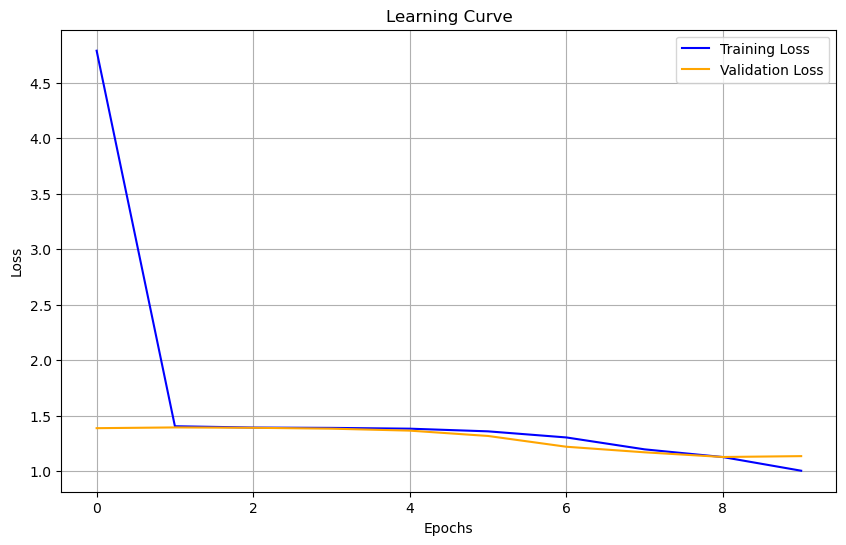

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation loss over epochs
def plot_learning_curve(history):
    train_loss = [epoch['train_loss'] for epoch in history]
    valid_loss = [epoch['valid_loss'] for epoch in history]

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(valid_loss, label='Validation Loss', color='orange')
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Accessing the history of the model to plot the learning curve
plot_learning_curve(net.history)


ROC-AUC Score: 0.87


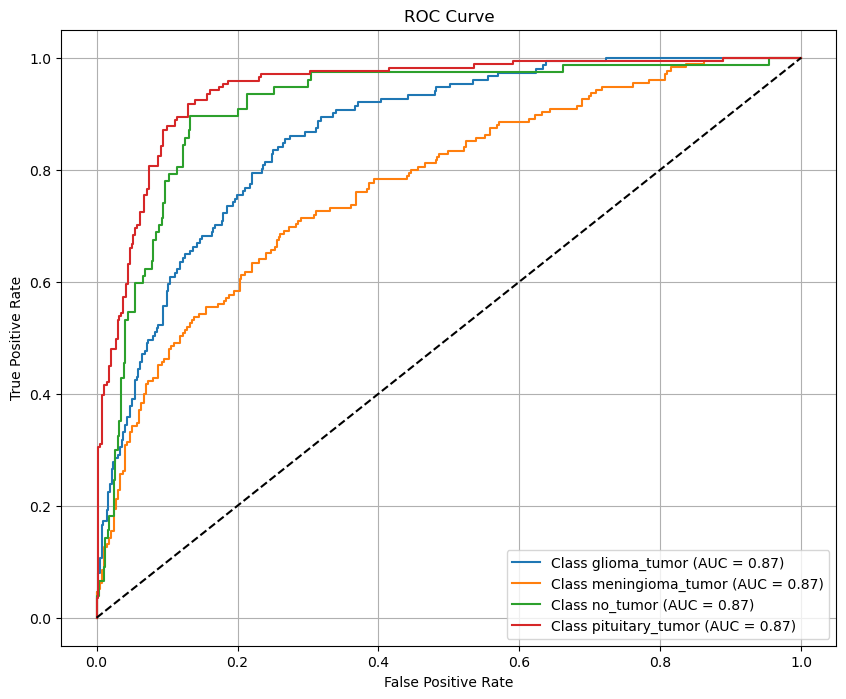

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

# Get predictions and true labels for the validation set
with torch.no_grad():
    y_pred_proba = net.predict_proba(X_val)  # Get predicted probabilities for each class
    y_true = y_val.numpy()  # Convert y_val to NumPy for use with sklearn

# Compute ROC-AUC score for each class
auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
print(f'ROC-AUC Score: {auc_score:.2f}')

# Compute ROC curve for each class
fpr = {}
tpr = {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(True)
plt.show()


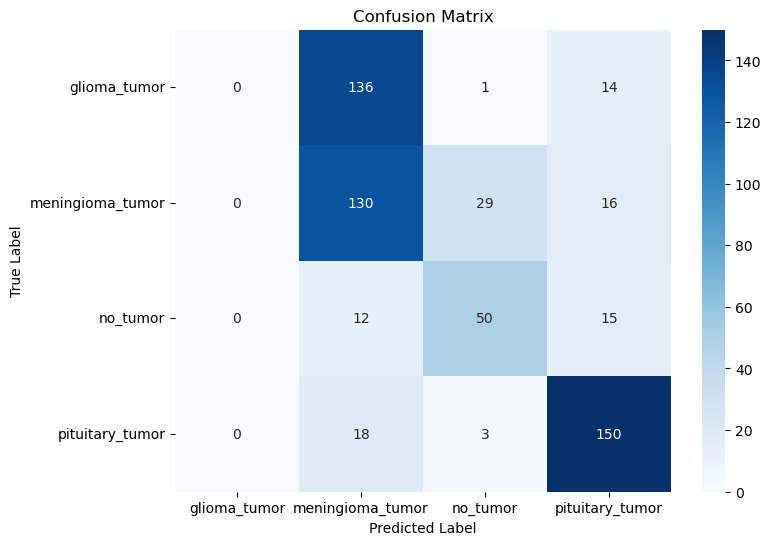

                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       151
meningioma_tumor       0.44      0.74      0.55       175
        no_tumor       0.60      0.65      0.62        77
 pituitary_tumor       0.77      0.88      0.82       171

        accuracy                           0.57       574
       macro avg       0.45      0.57      0.50       574
    weighted avg       0.44      0.57      0.50       574



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predicted classes
y_pred = net.predict(X_val)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall, and F1 Score for each class
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Precision: 0.44
Recall: 0.57
F1 Score: 0.50


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# Define the path where you want to save the model
model_save_path = '/home/ec2-user/SageMaker/ML-Algorithm-Benchmarks/models/cnn_model.pth'

# Save the trained model
torch.save(net.module_.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /home/ec2-user/SageMaker/ML-Algorithm-Benchmarks/models/cnn_model.pth
